In [1]:
import numpy as np
import glob
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize

import tensorflow as tf
#from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, Input, Convolution1D, Conv1D
import pickle
# pickle.dump(features, open("features.txt", "wb"))
# pickle.dump(labels, open("labels.txt", "wb"))

In [2]:
# Read data
features = pickle.load(open("/home/mids-w251-fa2020-fp/features.txt", "rb"))
labels = pickle.load(open("/home/mids-w251-fa2020-fp/labels.txt", "rb"))

In [3]:
X = np.array(features)
print(X.shape)

(259, 440, 12, 1)


In [4]:
Y = np.array(labels)
print(Y.shape)

(259,)


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=24601)

In [6]:
X_train.shape

(220, 440, 12, 1)

In [7]:
# normalize

train_mean = np.nanmean(X_train, axis=0, keepdims = True)
train_std = np.nanstd(X_train, axis=0, keepdims = True)

# train_mean = np.hstack((np.zeros((440, 1, 1)), train_mean))
# train_std = np.hstack((np.ones((440, 1, 1)), train_std))

train_mean.shape

(1, 440, 12, 1)

In [8]:
X_train_sc = np.nan_to_num((X_train - train_mean)/train_std)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [9]:
X_test_sc = np.nan_to_num((X_test - train_mean)/train_std)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


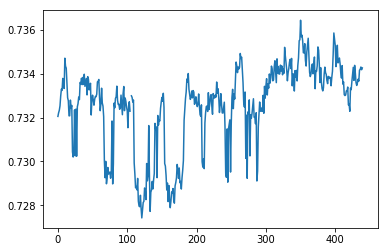

In [10]:
plt.plot(X_train[4][:,6,:])

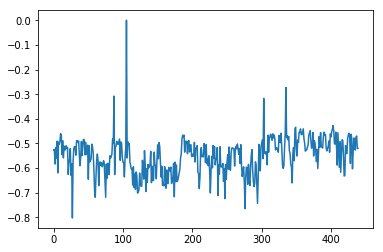

In [11]:
plt.plot(X_train_sc[4][:,6,:])

In [12]:
Y_train[4]

37

### Create a function to FFT transform

In [13]:
from scipy import fftpack

def find_br_fft(x):
    x = pd.Series(x).interpolate().tolist()
    tr = np.absolute(np.fft.fft(x))
    cycles_in_period = 1+np.argmax(tr[1:30])
    #print("cycles in period: ", cycles_in_period)
    brpm = cycles_in_period * (30 * 60 / 440)
    # plt.plot(X)
    #print("breathing rate per minute:  ", brpm)
    return brpm

find_br_fft(X_train_sc[4][:,6,0])

4.090909090909091

In [14]:
def find_sample_freq(df, fps = 30):
    '''Given a single sample, with dimension [440, 12, 1], predict frequency for all 12 x 1 keypoints. '''
    
    n_frames = df.shape[0]
    n_kps = df.shape[1]
    n_dims = df.shape[2]
    
    rslt = []
    
    for i in range(n_dims): 
        for j in range(n_kps): 
            x = df[:,j,i] 
            rslt += [find_br_fft(x)]
    return rslt

find_sample_freq(X_train_sc[4])

[4.090909090909091,
 4.090909090909091,
 4.090909090909091,
 4.090909090909091,
 4.090909090909091,
 4.090909090909091,
 4.090909090909091,
 4.090909090909091,
 4.090909090909091,
 36.81818181818182,
 4.090909090909091,
 4.090909090909091]

In [15]:
# find sample freq for all keypoints
X_train_fft = np.asarray(list(map(find_sample_freq,X_train_sc)))
X_test_fft = np.asarray(list(map(find_sample_freq,X_test_sc)))

In [16]:
type(X_train_fft)

numpy.ndarray

In [17]:
X_train_fft

array([[ 4.09090909,  4.09090909,  4.09090909, ..., 24.54545455,
        24.54545455, 24.54545455],
       [ 4.09090909,  4.09090909,  4.09090909, ..., 77.72727273,
         4.09090909, 40.90909091],
       [ 4.09090909,  8.18181818,  4.09090909, ..., 16.36363636,
         4.09090909,  4.09090909],
       ...,
       [ 8.18181818,  4.09090909,  4.09090909, ...,  4.09090909,
         4.09090909,  4.09090909],
       [ 4.09090909,  4.09090909,  4.09090909, ...,  8.18181818,
         8.18181818,  8.18181818],
       [ 4.09090909, 16.36363636,  4.09090909, ...,  8.18181818,
        16.36363636,  8.18181818]])

### Building a feed forward model on FFT results

In [18]:
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Conv2D, Dense, Flatten

model1_in = Input(shape=(12,))
model1_dense_1 = Dense(32, activation='relu')(model1_in)
model1_dense_2 = Dense(8, activation='relu')(model1_dense_1)
model1_out = Dense(1, activation='linear')(model1_dense_2)
model1 = Model(model1_in, model1_out)


model1.compile(loss="mse", optimizer='adam', metrics=["mse", "mae"])
model1.summary()


Using TensorFlow backend.


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                416       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 689
Trainable params: 689
Non-trainable params: 0
_________________________________________________________________


In [19]:
model1_results = model1.fit(X_train_fft, Y_train, epochs=300, validation_split=0.1)


Train on 198 samples, validate on 22 samples
Epoch 1/300
198/198 [==============================] - 2s 11ms/step - loss: 696.5394 - mse: 696.5394 - mae: 24.4756 - val_loss: 732.0570 - val_mse: 732.0570 - val_mae: 25.2764
Epoch 2/300
198/198 [==============================] - 0s 712us/step - loss: 678.4611 - mse: 678.4610 - mae: 24.1323 - val_loss: 723.4688 - val_mse: 723.4688 - val_mae: 25.1340
Epoch 3/300
198/198 [==============================] - 0s 704us/step - loss: 662.6429 - mse: 662.6429 - mae: 23.8036 - val_loss: 709.6974 - val_mse: 709.6974 - val_mae: 24.8806
Epoch 4/300
198/198 [==============================] - 0s 626us/step - loss: 642.8124 - mse: 642.8124 - mae: 23.3812 - val_loss: 691.3561 - val_mse: 691.3561 - val_mae: 24.5278
Epoch 5/300
198/198 [==============================] - 0s 565us/step - loss: 621.1401 - mse: 621.1401 - mae: 22.8998 - val_loss: 669.5137 - val_mse: 669.5137 - val_mae: 24.0866
Epoch 6/300
198/198 [==============================] - 0s 650us/step -

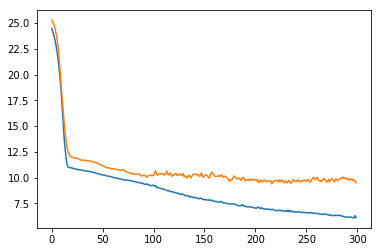

In [20]:
plt.plot(model1_results.history['mae'])
plt.plot(model1_results.history['val_mae'])

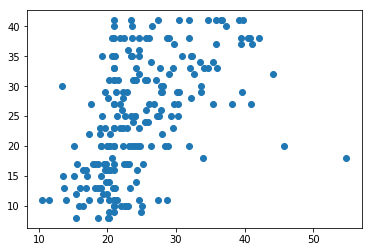

In [21]:
plt.scatter(model1.predict(X_train_fft), Y_train)

In [22]:
model1.evaluate(X_test_fft, Y_test)

39/39 [==============================] - 0s 379us/step


[79.01324149889824, 79.01323699951172, 7.155375957489014]

### Building a CNN model on keypoints

In [23]:
from keras.layers import Dense, Input, Conv2D, Dense, Flatten, Conv3D

model2_in = Input(shape=(440, 12, 1))
model2_conv2d = Conv2D(filters=16, kernel_size=(30,12),strides=(2), data_format='channels_last',activation='relu')(model2_in)
model2_flatten = Flatten()(model2_conv2d)
model2_hidden = Dense(16, activation='relu')(model2_flatten)
model2_out = Dense(1, activation = 'linear')(model2_hidden)
model2 = Model(model2_in, model2_out)

model2.compile(loss="mse", optimizer='adam', metrics=["mse", "mae"])
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 440, 12, 1)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 206, 1, 16)        5776      
_________________________________________________________________
flatten_1 (Flatten)          (None, 3296)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                52752     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 58,545
Trainable params: 58,545
Non-trainable params: 0
_________________________________________________________________


In [24]:
model2_results = model2.fit(X_train_sc, Y_train, epochs=300, validation_split=0.1)

Train on 198 samples, validate on 22 samples
Epoch 1/300
198/198 [==============================] - 7s 33ms/step - loss: 521.8648 - mse: 521.8649 - mae: 20.0829 - val_loss: 501.6925 - val_mse: 501.6925 - val_mae: 16.7981
Epoch 2/300
198/198 [==============================] - 0s 706us/step - loss: 294.5885 - mse: 294.5884 - mae: 12.7056 - val_loss: 212.2784 - val_mse: 212.2784 - val_mae: 12.0171
Epoch 3/300
198/198 [==============================] - 0s 703us/step - loss: 184.0077 - mse: 184.0077 - mae: 10.6216 - val_loss: 220.8474 - val_mse: 220.8474 - val_mae: 12.1017
Epoch 4/300
198/198 [==============================] - 0s 651us/step - loss: 167.2978 - mse: 167.2978 - mae: 10.0714 - val_loss: 242.2135 - val_mse: 242.2135 - val_mae: 12.2531
Epoch 5/300
198/198 [==============================] - 0s 680us/step - loss: 141.5735 - mse: 141.5735 - mae: 9.5010 - val_loss: 202.4314 - val_mse: 202.4314 - val_mae: 11.5120
Epoch 6/300
198/198 [==============================] - 0s 668us/step - l

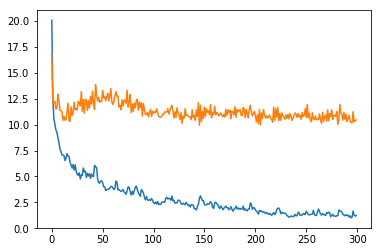

In [25]:
plt.plot(model2_results.history['mae'])
plt.plot(model2_results.history['val_mae'])

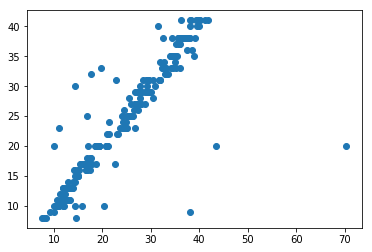

In [26]:
plt.scatter(model2.predict(X_train_sc), Y_train)

In [27]:
model2.evaluate(X_test_sc, Y_test)

39/39 [==============================] - 0s 4ms/step


[78.28283984844501, 78.2828369140625, 6.472908020019531]

### Create an ensemble model

In [28]:
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers import Dense, Input, Conv2D, Dense, Flatten

model1_in = Input(shape=(12,))
model1_out = Dense(12, activation='relu')(model1_in)
model1 = Model(model1_in, model1_out)


model1.compile(loss="mse", optimizer='adam', metrics=["mse", "mae"])
model1.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 12)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)                156       
Total params: 156
Trainable params: 156
Non-trainable params: 0
_________________________________________________________________


In [29]:
from keras.layers import Dense, Input, Conv2D, Dense, Flatten, Conv3D, Dropout

model2_in = Input(shape=(440, 12, 1))
model2_conv2d = Conv2D(filters=16, kernel_size=(30,12),strides=(2), data_format='channels_last',activation='relu')(model2_in)
model2_out = Flatten()(model2_conv2d)
model2 = Model(model2_in, model2_out)

model2.compile(loss="mse", optimizer='adam', metrics=["mse", "mae"])
model2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 440, 12, 1)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 206, 1, 16)        5776      
_________________________________________________________________
flatten_2 (Flatten)          (None, 3296)              0         
Total params: 5,776
Trainable params: 5,776
Non-trainable params: 0
_________________________________________________________________


In [30]:
concatenated = concatenate([model1_out, model2_out])
hidden1 = Dense(64, activation='relu', name='hidden1')(concatenated)
dropout = Dropout(0.1)(hidden1)
hidden2 = Dense(8, activation='relu', name='hidden3')(dropout)
out = Dense(1, activation='linear', name='output_layer')(hidden2)

merged_model = Model([model1_in, model2_in], out)
merged_model.compile(loss='mse', optimizer='adam', metrics=["mse", "mae"])

merged_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 440, 12, 1)   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 206, 1, 16)   5776        input_4[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 12)           156         input_3[0][0]                    
____________________________________________________________________________________________

In [31]:
history = merged_model.fit([X_train_fft, X_train_sc], y=Y_train, epochs=300, validation_split=0.1, shuffle=True)

Train on 198 samples, validate on 22 samples
Epoch 1/300
198/198 [==============================] - 1s 6ms/step - loss: 540.2984 - mse: 540.2984 - mae: 20.9541 - val_loss: 310.2801 - val_mse: 310.2801 - val_mae: 14.5853
Epoch 2/300
198/198 [==============================] - 0s 859us/step - loss: 349.5683 - mse: 349.5682 - mae: 14.0094 - val_loss: 234.5950 - val_mse: 234.5950 - val_mae: 12.3826
Epoch 3/300
198/198 [==============================] - 0s 936us/step - loss: 187.2771 - mse: 187.2771 - mae: 10.6250 - val_loss: 221.9785 - val_mse: 221.9785 - val_mae: 13.0271
Epoch 4/300
198/198 [==============================] - 0s 920us/step - loss: 166.6274 - mse: 166.6274 - mae: 10.0902 - val_loss: 223.1340 - val_mse: 223.1340 - val_mae: 12.5261
Epoch 5/300
198/198 [==============================] - 0s 833us/step - loss: 142.3903 - mse: 142.3903 - mae: 9.5348 - val_loss: 248.8174 - val_mse: 248.8174 - val_mae: 12.3875
Epoch 6/300
198/198 [==============================] - 0s 854us/step - lo

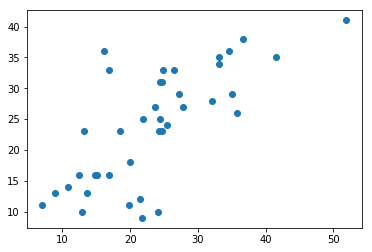

In [32]:
plt.scatter(merged_model.predict([X_test_fft, X_test_sc]), Y_test)

In [33]:
merged_model.evaluate([X_test_fft, X_test_sc], Y_test)

39/39 [==============================] - 0s 836us/step


[49.00862150925856, 49.00862121582031, 5.209015846252441]

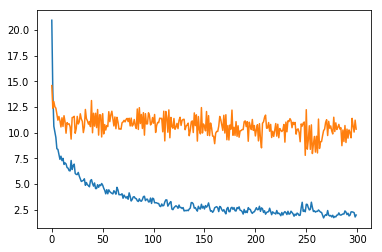

In [34]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])